# KNN

Libraries:
- Data management:
    - [numpy](https://numpy.org/)
    - [pandas](https://pandas.pydata.org/)
- Modelling and scoring:
    - [scikit-learn](https://scikit-learn.org)
- Plotting:
    - [matplotlib](https://matplotlib.org/)

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import sklearn.neighbors as sk

import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from utils import evaluate_classification_metrics

Here I import the `creditcard.csv` dataset, obtained from [Kaggle - Credit Card Fraud Detection](https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud). The dataset contains 284,807 transactions, of which 492 are fraudulent. The goal is to predict whether a transaction is fraudulent or not based on the features provided.
I remove the `Time` column, as it is not relevant for the model. I also remove the `Class` column from the features, as it is the target variable. I then split the data into training and testing sets, with 80% of the data used for training and 20% for testing.

In [3]:
df = pd.read_csv("creditcard.csv", sep = ",")

X = df.iloc[:, 1:-1].values
# Get the last column as the target
y = df.iloc[:, -1].values

# Convert the pandas dataframes into np.arrays so that we can use all the previous codes we defined
X = np.array(X)
y = np.array(y)

Code to divide the dataset

In [4]:
def train_test_split(X, y, test_size=0.2, stratify=y, random_state=42):
    """
    Splits arrays or matrices into random train and test subsets. This function demonstrates how to 
    divide a dataset into training and testing sets, optionally stratifying the samples and ensuring 
    reproducibility with a random state.

    Parameters:
    - X (np.ndarray): Input features matrix, where rows represent samples and columns represent features.
    - y (np.ndarray): Target labels array, aligned with the samples in X.
    - test_size (float or int): Determines the size of the test set. If float, it represents a proportion 
                                of the dataset; if int, it specifies the number of samples.
    - stratify (np.ndarray): If provided, the function will ensure the class proportions in train and test 
                             sets mirror those of the provided array, typically the target labels array.
    - random_state (int): Seed for the random number generator to ensure reproducible splits.

    Returns:
    - X_train, X_test, y_train, y_test: Arrays containing the split of features and labels into training and 
                                        test sets.
    """
    
    # Set the seed for reproducibility
    if random_state:
        np.random.seed(random_state)

    # Determine the number of samples to allocate to the test set
    n_samples = X.shape[0]
    if isinstance(test_size, float):
        n_test = int(n_samples * test_size)
    else:
        n_test = test_size
    n_train = n_samples - n_test

    # Create an array of indices and shuffle if not stratifying
    indices = np.arange(n_samples)
    if stratify is None:
        np.random.shuffle(indices)
    else:
        # For stratified splitting, determine the distribution of classes
        unique_classes, y_indices = np.unique(stratify, return_inverse=True)
        class_counts = np.bincount(y_indices)
        test_counts = np.round(class_counts * test_size).astype(int)

        # Allocate indices to train and test sets preserving class distribution
        train_indices, test_indices = [], []
        for class_index in range(len(unique_classes)):
            class_indices = indices[y_indices == class_index]
            np.random.shuffle(class_indices)
            boundary = test_counts[class_index]
            test_indices.extend(class_indices[:boundary])
            train_indices.extend(class_indices[boundary:])

        # Concatenate indices to form the final split
        indices = train_indices + test_indices

    # Use the indices to partition the dataset
    X_train = X[indices[:n_train]]
    X_test = X[indices[n_train:]]
    y_train = y[indices[:n_train]]
    y_test = y[indices[n_train:]]

    return X_train, X_test, y_train, y_test


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

## Training the KNN model

Now, it comes the turn to train the KNN.

In [10]:
knn = sk.KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

evaluate_classification_metrics(y_test, knn.predict(X_test), 1)

{'Confusion Matrix': [np.int64(71072),
  np.int64(6),
  np.int64(36),
  np.int64(87)],
 'Accuracy': np.float64(0.999410120644373),
 'Precision': np.float64(0.9354838709677419),
 'Recall': np.float64(0.7073170731707317),
 'Specificity': np.float64(0.999915585694589),
 'F1 Score': np.float64(0.8055555555555556)}

Ready predictions


C:\Users\EMINE\AppData\Local\Temp\ipykernel_17132\3257266734.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([''] + listclasses, rotation=90)
C:\Users\EMINE\AppData\Local\Temp\ipykernel_17132\3257266734.py:24: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels([''] + listclasses)


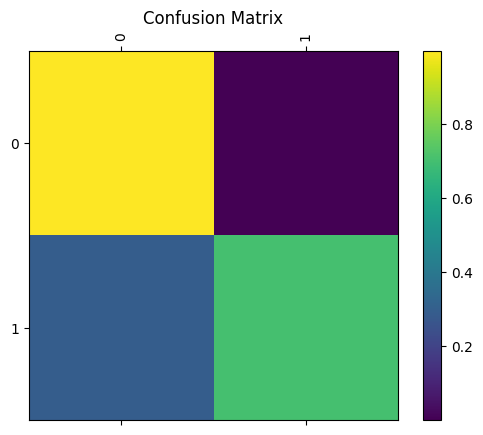

[[9.99912069e-01 8.79306403e-05]
 [2.95918367e-01 7.04081633e-01]]


In [8]:
# CONFUSION MATRIX
listclasses = ['0', '1']
numclasses = 2

confusion = np.zeros((numclasses, numclasses))
predictions = knn.predict(X_test)
print("Ready predictions")
for i in range(len(y_test)):
    confusion[int(y_test[i]), int(predictions[i])] += 1

# Normalize by dividing every row by its sum
for i in range(numclasses):
    confusion[i] = confusion[i] / confusion[i].sum()

# Set up plot
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(confusion, cmap='viridis')
plt.title('Confusion Matrix')
fig.colorbar(cax)

# Set up axes
ax.set_xticklabels([''] + listclasses, rotation=90)
ax.set_yticklabels([''] + listclasses)

# Force label at every tick
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

# sphinx_gallery_thumbnail_number = 2
plt.show()
print (confusion)

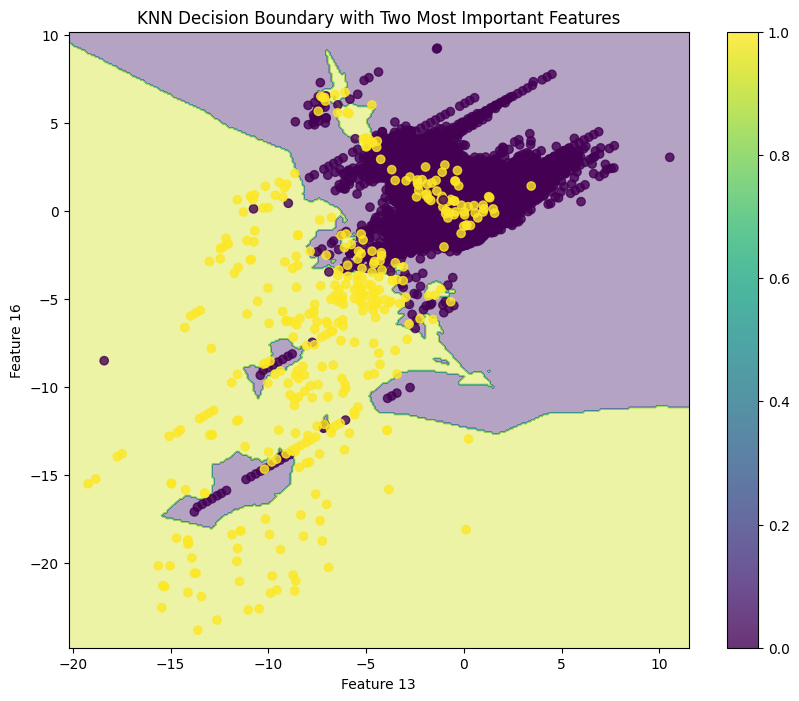

In [11]:
# Keep the two most important features for visualization
from sklearn.feature_selection import SelectKBest, f_classif

# Select 2 best features
selector = SelectKBest(score_func=f_classif, k=2)
X_train_reduced = selector.fit_transform(X_train, y_train)
X_test_reduced = selector.transform(X_test)

# Get the indices of selected features
selected_features = selector.get_support(indices=True)

# Create mesh grid for visualization
x_min, x_max = X_train_reduced[:, 0].min() - 1, X_train_reduced[:, 0].max() + 1
y_min, y_max = X_train_reduced[:, 1].min() - 1, X_train_reduced[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

# Train KNN on reduced features
knn_viz = sk.KNeighborsClassifier(n_neighbors=3)
knn_viz.fit(X_train_reduced, y_train)

# Make predictions on mesh grid
Z = knn_viz.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

# Plot decision boundary
plt.figure(figsize=(10, 8))
plt.contourf(xx, yy, Z, alpha=0.4)
plt.scatter(X_train_reduced[:, 0], X_train_reduced[:, 1], c=y_train, alpha=0.8)
plt.xlabel(f'Feature {selected_features[0]}')
plt.ylabel(f'Feature {selected_features[1]}')
plt.title('KNN Decision Boundary with Two Most Important Features')
plt.colorbar()
plt.show()
